<h1>Optimization - MALIS project Key Estimation</h1>

Execute this cell to import everything needed

In [1]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from loading_dataset import prepare_panda_dataFrame
import pandas as pd

LOADING DATASETS

In [2]:
# Run this to create a csv file of a dataset
dataset_path="./Datasets/giantsteps-key-dataset-master/audio"
key_annotation_path="./Datasets/giantsteps-key-dataset-master/annotations/key"
chroma_df=prepare_panda_dataFrame(dataset_path,key_annotation_path)

loading ./Datasets/giantsteps-key-dataset-master/audio
What transformation would you like to perform on your dataset,
enter 1 for chromagram, 2 for spectrogram:1
1
Processing data, please wait


/home/mirado/anaconda3/lib/python3.8/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
/home/mirado/GIT/AI-Key-Detection-Project/loading_dataset.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  audio_key_tuples = np.array(audio_key_tuples)


Audios have correctly been processed 

Do you want to register data into dataframe ? [yes: enter 1/no: enter 0]:0


In [3]:
dataset_path = "/home/mirado/GIT/AI-Key-Detection-Project/Datasets/giantsteps-mtg-key-dataset-master/audio/wav/"
key_annotation_path = "/home/mirado/GIT/AI-Key-Detection-Project/Datasets/giantsteps-mtg-key-dataset-master/annotations/mtg_annotations_key/"
chroma_mtg_df=prepare_panda_dataFrame(dataset_path,key_annotation_path)

loading /home/mirado/GIT/AI-Key-Detection-Project/Datasets/giantsteps-mtg-key-dataset-master/audio/wav/
What transformation would you like to perform on your dataset,
enter 1 for chromagram, 2 for spectrogram:1
1
Processing data, please wait


/home/mirado/anaconda3/lib/python3.8/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


Audios have correctly been processed 

Do you want to register data into dataframe ? [yes: enter 1/no: enter 0]:0


-------------------- KFold --------------------

In [6]:
    # Neural network parameters
    epochs = 500
    iter_for_convergence = epochs
    hidden_layer_sizes = (100,50,30) # these represents the number of neurons IN THE HIDDEN LAYERS ONLYS
    activation = 'logistic'
    validation= True;
    verbose=False;
    learning_rate = 0.008
    
    # Regularization constant
    alpha=0.0

    # NNet init
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, 
                        random_state=1, max_iter=epochs, learning_rate_init=learning_rate, 
                        learning_rate='adaptive', alpha=alpha, early_stopping=validation, 
                        verbose=verbose, n_iter_no_change=iter_for_convergence)

In [7]:
# Preparation of training data
#spectro_gs_df = pd.read_csv("giantsteps_spectro.csv")

X, y = np.stack(chroma_df['chromagram']), np.array(chroma_df['coded_key'].astype('int'))

In [8]:
kfold = KFold(n_splits=5)
skfold = StratifiedKFold(5)

y_array_kfold = cross_val_score(mlp, X, y, cv=kfold)
y_array_skfold = cross_val_score(mlp, X, y, cv=skfold)

/home/mirado/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mirado/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mirado/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mirado/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mirado/anaconda3/lib/python3.8/sit

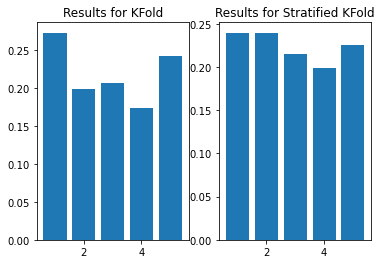

In [9]:
# Ploting the results
x = [i for i in range(1,6)]

for i in range(2):
    plt.subplot(1,2,i+1)
    if i==0:
        plt.bar(x, y_array_kfold)
        plt.title("Results for KFold")
    if i==1: 
        plt.bar(x, y_array_skfold)
        plt.title("Results for Stratified KFold")

In [15]:
print("Average accuracy for 5-Fold:", round(y_array_kfold.mean()*100, 2),"%")
print("Average accuracy for Stratified 5-Fold:", round(y_array_skfold.mean()*100,2), "%")

Average accuracy for 5-Fold: 21.86 %
Average accuracy for Stratified 5-Fold: 22.35 %


We recover the best split from the Stratified KFold as it has a better result in terms of accuracy.

In [16]:
accuracy = []
skfold.get_n_splits(X,y)

index = 1
counter = 0

for train_indexes, test_indexes in skfold.split(X,y):
    if (counter == index):
        X_train, X_test = X[train_indexes], X[test_indexes]
        y_train, y_test = y[train_indexes], y[test_indexes]
        break
    counter +=1

/home/mirado/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


-------------------- GRID SEARCH --------------------

In [17]:
# Creating the MLP Classifier and initiating all values for that
epochs = 400
iter_for_convergence = epochs
hidden_layer_sizes = (100,50,30) # these represents the number of neurons IN THE HIDDEN LAYERS ONLYS
activation = 'logistic'
validation= True;
verbose=False;

#mlp = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, activation=activation,
#                   random_state=1, early_stopping=validation,
#                   verbose=verbose, n_iter_no_change=iter_for_convergence)

parameters_dict = {
    'alpha': [0.0001, 0.05],
    'learning_rate_init': [10**-5, 10**-4, 10**-3, 10**-2]
}

#mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, 
#                        random_state=1, max_iter=epochs, 
#                        learning_rate='adaptive', early_stopping=validation, 
#                        verbose=verbose, n_iter_no_change=iter_for_convergence)

In [18]:
# Performing Gridsearch on the parameters

# n_jobs = number of cores to use (-1 = all available)
# cv = number of splits for cross validation

clf = GridSearchCV(mlp, parameters_dict, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)
#mlp.fit(X_train, y_train)

/home/mirado/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/mirado/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', alpha=0.0,
                                     early_stopping=True,
                                     hidden_layer_sizes=(100, 50, 30),
                                     learning_rate='adaptive',
                                     learning_rate_init=0.008, max_iter=500,
                                     n_iter_no_change=500, random_state=1),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.05],
                         'learning_rate_init': [1e-05, 0.0001, 0.001, 0.01]})

In [21]:
df_results = pd.DataFrame(clf.cv_results_)
df_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_learning_rate_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,18.961269,0.359053,0.003921,0.000625,0.0001,1e-05,"{'alpha': 0.0001, 'learning_rate_init': 1e-05}",0.092784,0.082474,0.082474,0.093750,0.093750,0.089046,0.005378,7
1,19.406257,0.624792,0.004230,0.000564,0.0001,0.0001,"{'alpha': 0.0001, 'learning_rate_init': 0.0001}",0.134021,0.144330,0.185567,0.187500,0.208333,0.171950,0.028116,3
2,20.016181,0.470826,0.004191,0.000510,0.0001,0.001,"{'alpha': 0.0001, 'learning_rate_init': 0.001}",0.237113,0.226804,0.195876,0.187500,0.208333,0.211125,0.018546,1
3,20.750339,0.396378,0.005309,0.001162,0.0001,0.01,"{'alpha': 0.0001, 'learning_rate_init': 0.01}",0.175258,0.123711,0.175258,0.187500,0.187500,0.169845,0.023708,4
4,20.963482,0.342977,0.004910,0.000453,0.05,1e-05,"{'alpha': 0.05, 'learning_rate_init': 1e-05}",0.092784,0.082474,0.082474,0.093750,0.093750,0.089046,0.005378,7
5,20.095812,0.356940,0.004153,0.000306,0.05,0.0001,"{'alpha': 0.05, 'learning_rate_init': 0.0001}",0.123711,0.113402,0.154639,0.177083,0.208333,0.155434,0.034758,6
6,19.987140,0.271122,0.003306,0.000621,0.05,0.001,"{'alpha': 0.05, 'learning_rate_init': 0.001}",0.206186,0.154639,0.144330,0.104167,0.197917,0.161448,0.037288,5
7,10.091994,4.649891,0.001523,0.000275,0.05,0.01,"{'alpha': 0.05, 'learning_rate_init': 0.01}",0.175258,0.247423,0.185567,0.187500,0.197917,0.198733,0.025385,2


In [23]:
df_results[['param_alpha', 'param_learning_rate_init','mean_test_score']]

,param_alpha,param_learning_rate_init,mean_test_score
0,0.0001,1e-05,0.089046
1,0.0001,0.0001,0.171950
2,0.0001,0.001,0.211125
3,0.0001,0.01,0.169845
4,0.05,1e-05,0.089046
5,0.05,0.0001,0.155434
6,0.05,0.001,0.161448
7,0.05,0.01,0.198733


In [24]:
clf.best_params_

{'alpha': 0.0001, 'learning_rate_init': 0.001}